In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
from sklearn.linear_model import LinearRegression as regression_sk
import os
import math
os.chdir("/Users/simonedigregorio/Downloads/archive")

In [6]:
cols = pd.read_csv("instagram_posts.csv", delimiter="\t", nrows = 1).columns.values.tolist()
ignore_col = ("description", "post_id")
posts = pd.read_csv("instagram_posts.csv", delimiter="\t", parse_dates=[4],infer_datetime_format = True, usecols= [x for x in cols if x not in ignore_col])

In [ ]:
# Plot a scatter plot of “likes” vs comments for posts
# ylim and xlim are used in order to make the scatterplot a bit more readable

plt.figure(figsize=(20, 8))
plt.scatter(posts["numbr_likes"], posts["number_comments"])
plt.ylabel("Number of comments")
plt.xlabel("Number of likes")
plt.xlim([0, 4*10**6])
plt.ylim([0, 200000])
plt.show()

In [ ]:
# A way to check the linear (only the linear) relationship would be to use Pearson's correlation coefficient (i.e. standardized covariance). Intuitively, the amount of covariance between (the numbers of) likes and comments cannot be zero, so it makes sense that the correlation coefficient is significant (0.37), albeit not high.

print("Pearson's Correlation coefficient for number of likes and the number of comments: {}".format(round(posts[["numbr_likes", "number_comments"]].corr().iloc[0, 1], 2)))

In [ ]:
# Let's check the relationship also with a linear regression
posts_complete_lc = posts[["numbr_likes", "number_comments"]].dropna()
coeff, covariance_matrix = np.polyfit(posts_complete_lc["numbr_likes"], posts_complete_lc["number_comments"], deg = 1, cov = "unscaled")
var1, var2 = covariance_matrix[[0, 1], [0, 1]]

In [ ]:
plt.figure(figsize=(20, 8))
ax = plt.gca()
ax.axline((0, coeff[0]), slope = coeff[1], linewidth = 5, c = "red")
ax.scatter(posts_complete_lc["numbr_likes"], posts_complete_lc["number_comments"])
plt.xlim([0, 200])
plt.xlabel("Number of likes")
plt.ylabel("Number of comments")
plt.ylim([0, 500])
plt.show()

# Print also p-value for the coefficients of the regression (simple t-test)
# We assume homoscedasticity (since the covariance matrix of the coefficients uses the estimated variance of the residuals), which is a very unrealistic assumption in this case, but still. t-distribution at this point is basically the normal (due to the very high number of degrees of freedom), so we can use that and disregard the t.
print("p-value for intercept: {}".format(1-stats.norm.cdf((coeff[0]-0)/np.sqrt(var1))))
print("p-value for slope: {}".format(1-stats.norm.cdf((coeff[1]-0)/np.sqrt(var2))))

In [ ]:
# Check the existence of a relationship between time and number of comments and likes
# A good way to do that would be to discretize the time and then perform a chi-square test

# Let's assume that if there is no relationship between likes/comments and time the distribution of likes per post/comments per post is homogeneous across time, which makes sense. This is our null hypothesis. Under our null hypothesis, in more formal terms, the following behaviour emerges: the frequency (likes/comments) for the specific timeframe/hour is approximately distributed as a random variable centered on the expected frequency given by our null hypothesis, which is simply the total number of likes/comments divided by 24 and normalized by the mean number of posts in an hour. Since we have multiple timeframes/hours, we use the fact that the sum of n standardized squared normal r.v. is modelled by a chi-square with n degrees of freedom.
# This is a one sided test because we are checking the right tail because this is a goodness of fit (it is not like a test of variance where we have to consider it two-sided)

$\sum_{h=1}^{24}\frac{\left(\frac{f_h}{n_h} - \frac{f_T}{24\cdot n_h}\right)^2}{\frac{f_T}{24 \cdot n_h}} = \sum_{h=1}^{24}\frac{\left(f_h - \frac{f_T}{24}\right)^2}{\frac{f_T}{24}\cdot n_h} \sim \chi_{23}^2$ \
\
where $n_h$ is the total number of posts in a specific hour.

In [ ]:
# Let's do this in practice (likes)
number_of_posts_hour = posts.cts.dt.hour.value_counts().sort_index()
likes_per_hour = posts["numbr_likes"].groupby(posts.cts.dt.hour).sum().sort_index()
test_statistic_chi = (((likes_per_hour-(likes_per_hour.mean()))**2)/(likes_per_hour.mean()*number_of_posts_hour)).sum()
print("p-value for chi-squared test (likes): {}".format(1-stats.chi2.cdf(test_statistic_chi, 23)))
print(f"Test statistic for chi-squared test: {round(test_statistic_chi, 2)}")
# It seems we can definitely reject our null hypothesis (the p-value is practically 0): the number of likes seems definitely not independent of the hour/timeframe

In [ ]:
test_statistic_chi

In [ ]:
likes_per_hour

In [ ]:
# Let's do this in practice (comments)
comments_per_hour = posts["number_comments"].groupby(posts.cts.dt.hour).sum().sort_index()
test_statistic_chi = (((comments_per_hour-(comments_per_hour.mean()))**2)/(comments_per_hour.mean()*number_of_posts_hour)).sum()
print("p-value for chi-squared test (comments): {}".format(1-stats.chi2.cdf(test_statistic_chi, 23)))
# The same we said above applies for comments

In [ ]:
# To check which kind of relationship we are talking about, let's do some overkill:
# Fourier Regression! Linear regression seems docile, but you can do literally whatever you want with the concept. One of the things is using a Fourier basis to transform the (single) predictor and fit a multivariate regression to estimate the Fourier coefficients. This is useful to estimate from real data the Fourier coefficients of an arbitrary periodic signal, such as the amount of likes during the day, something which we expect to be strongly periodic.

# Assuming that the period is even, like in this case, the expression of the model/of the Fourier series we have to fit is the one below.
# We assume the day (24 hours, which is even) as the seasonal period and thus $\frac{1}{P}$ as the fundamental frequency of the series.
# Also notice that sines and cosine are orthonormal functions and sinusoidal waves of different frequencies are orthonormal. So the linear regression should be pretty tame (since the predictors are uncorrelated).
# As before, we need some kind of normalization on the number of posts in the hour timeframe. $x$ is the number of posts

# source: Time Series Analysis and its Applications, fourth edition, pg. 171

$ f(x) = a_0 + \sum_{n = 1}^{N-1}\left(a_{n}\cdot cos\left(\frac{2\pi}{P}nx\right)+b_{n}\cdot sin\left(\frac{2\pi}{P}nx\right)\right) + a_N (-1)^x$ _with_ $N = \frac{P}{2} $

In [8]:
hourly_mean_likes = posts[["cts", "numbr_likes"]][posts["cts"]>"2013"].groupby(pd.Grouper(key = "cts", freq="H")).mean()/posts[["cts", "numbr_likes"]][posts["cts"]>"2013"].groupby(pd.Grouper(key = "cts", freq="H")).count()

hourly_mean_likes["time_int"] = range(2, len(hourly_mean_likes)+2)
hourly_mean_likes.dropna(inplace=True)

In [10]:
# fit a linear regression to remove trend (if present)
# The residuals are then used to fit the harmonic regression
trend_regression = regression_sk(fit_intercept=True, copy_X=False)
trend_regression = trend_regression.fit(np.expand_dims(hourly_mean_likes.time_int, axis = 1), hourly_mean_likes.numbr_likes)
# Below, the residual vector aka fitted values vector
residual_vector = trend_regression.predict(np.expand_dims(hourly_mean_likes.time_int, axis=1))-hourly_mean_likes.numbr_likes

In [11]:
# First, we need to transform the predictor in order to fit the harmonic regression. We compute cosine and sine terms from the univariate series.

armonic_mult = range(1, 12)

fourier_design_matrix = [(np.cos((2*np.pi/24)* n * hourly_mean_likes.time_int.to_numpy()), np.sin((2*np.pi/24)* n * hourly_mean_likes.time_int.to_numpy())) for n in armonic_mult]

fourier_design_matrix = [x for t in fourier_design_matrix for x in t]
fourier_design_matrix.append(np.power(-1, hourly_mean_likes.time_int.to_numpy()))
fourier_design_matrix = np.column_stack(fourier_design_matrix)

In [12]:
# Now we fit the harmonic/fourier regression, since we already fitted a linear regression with intercept, and we are using the residuals we do not need to fit the intercept.
fourier_regression = regression_sk(fit_intercept=False, copy_X=False)
fourier_regression = fourier_regression.fit(fourier_design_matrix, residual_vector)

In [13]:
fourier_regression.coef_[22]

0.922854078443843

In [14]:
# This function is necessary for plotting the result
def fourier_func(x:list[int], coeff:np.array, intercept:float, order:int, period:int) -> float:
    output_list = list()
    for time_index in x:
        output = 0
        for term_n in range(0, order-1):
            a, b = coeff[0+2*term_n], coeff[1+2*term_n]
            output += a*math.cos((2*math.pi/period)*(term_n+1)*time_index) + b*math.sin((2*math.pi/period)*(term_n+1)*time_index)
        output_list.append(output + intercept + coeff[-1]*(-1**time_index))
    return output_list

In [15]:
# Function test
fourier_func(list(range(1, 25)), fourier_regression.coef_, fourier_regression.intercept_, 12, 24)

[7.398626663143752,
 7.346781910357439,
 6.998007804944773,
 0.08817324289650053,
 7.199041260259557,
 2.607390392079639,
 -8.531113698758382,
 -8.43620206033893,
 -13.504221024762868,
 -2.564908068543084,
 -9.737183929654906,
 -12.64759741932762,
 -4.034393423806435,
 -15.032813140456708,
 -7.997232887078347,
 2.407821281936784,
 -11.55200112900573,
 -3.812759104663273,
 4.969651507428857,
 5.934864684405529,
 8.002972194362703,
 8.406912523209437,
 9.713597721600975,
 4.6280868171181275]

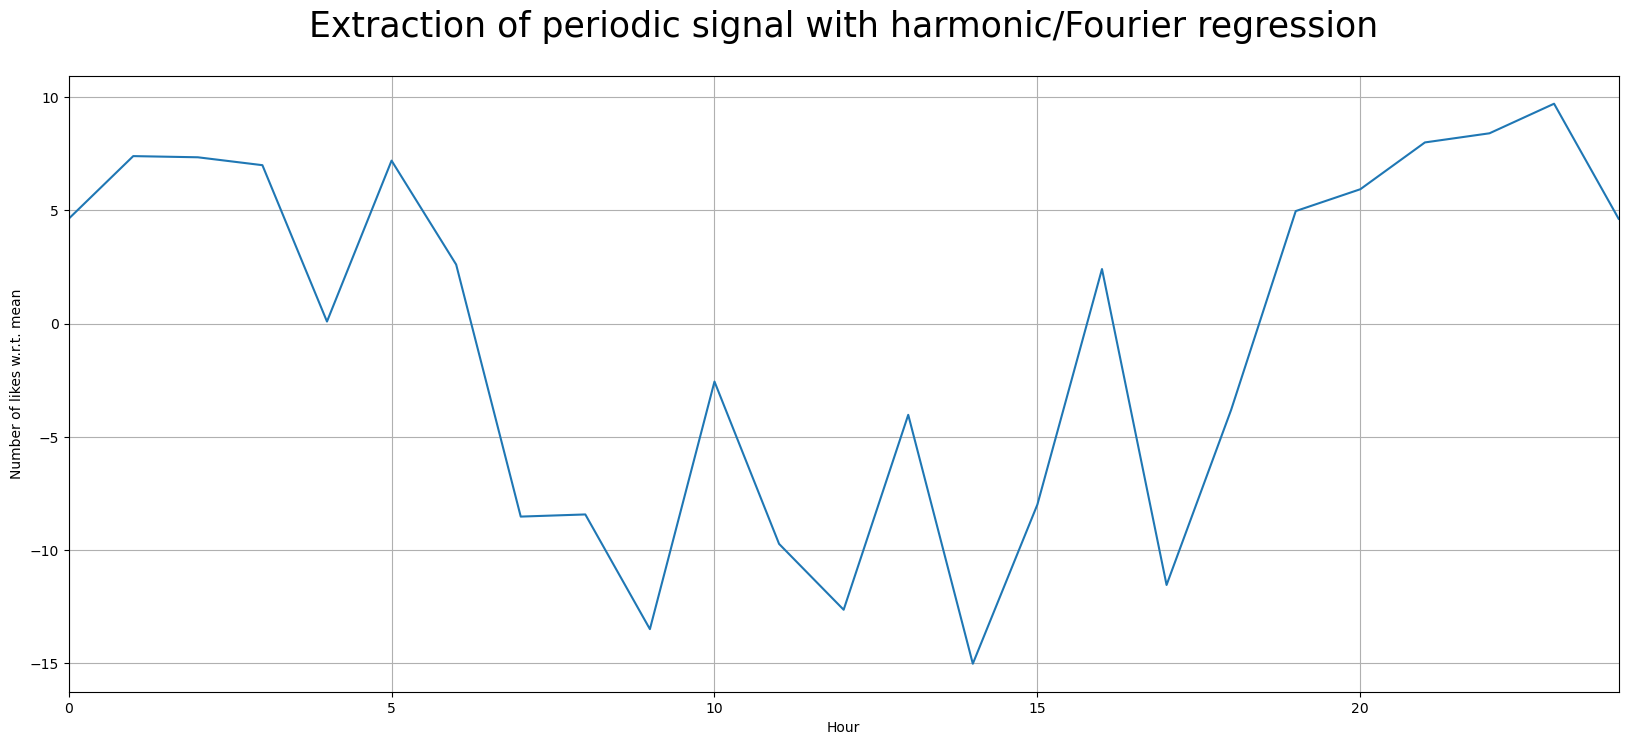

In [16]:
plt.figure(figsize=(20, 8))
plt.plot(list(range(0, 25)), fourier_func(list(range(0, 25)), fourier_regression.coef_, fourier_regression.intercept_, 12, 24))
plt.ylabel("Number of likes w.r.t. mean")
plt.xlabel("Hour")
plt.xlim((0, 24))
plt.grid(True)
plt.title("Extraction of periodic signal with harmonic/Fourier regression", fontdict={"fontsize": 25}, y = 1.05)
plt.show()

In [ ]:
# Distribution of followers

# Let's analyze the distribution of followers.

profiles = pd.read_csv("instagram_profiles.csv", delimiter="\t")

In [ ]:
print(profiles.followers.describe().iloc[1:].to_markdown())

print("Followers distro skewness: {}".format(profiles.followers.skew()))
print("Followers distro excess kurtosis: {}".format(profiles.followers.kurtosis()))
print("Followers distro mode: {}".format(profiles.followers.mode().values[0]))

# These are extremely distorted distros

# Again, as we have explained in RQ1, this is due to preferential attachment processes underlying social networks dynamics, which is even more intuitive, natural and clear when we think about the way profiles cluster in the directed social graph when looking at the edges represented by the follower connections. Intuitively, a new user is far more likely to follow a small set of users (VIPs) which have an already high number of followers, and this is basically the informal definition of a preferential attachment process.

In [ ]:
# High disparity in the network can be seen by the fact that the variable is log-normally distributed


# Histogram showing log normality

plt.figure(figsize=(20, 10))
plt.title("Histogram of the log-transformed number of followers", fontdict={"fontsize": 25}, y= 1.05)
plt.hist((profiles.followers+1).apply(np.log), bins=30)
plt.xlim(0, 13)
plt.show()

In [ ]:
quantiles_stdnorm = [stats.norm.ppf(x) for x in np.arange(0.05, 0.96, 0.05)]
log_transformed_followers = (profiles.followers+1).apply(np.log)
sample_quantiles_followers = ((log_transformed_followers-log_transformed_followers.mean())/log_transformed_followers.std()).quantile(np.arange(0.05, 0.96, 0.05))

plt.figure(figsize=(20, 10))
plt.suptitle("  Q-Q plot for log-distribution of the number of followers", fontsize = 30)
plt.title("Standard normal quantiles vs. quantiles of standardized sample distribution", fontsize = 20, y = 1.02)
ax = plt.gca()
ax.plot(quantiles_stdnorm, quantiles_stdnorm)
ax.scatter(quantiles_stdnorm, sample_quantiles_followers)
for standard, sample in zip(quantiles_stdnorm, sample_quantiles_followers):
    ax.plot([standard, standard], [standard, sample], c = "red", alpha = 0.5)
plt.show()